In [ ]:
!pip install ultralytics

In [ ]:
!pip install easyocr

In [ ]:
from ultralytics import YOLO
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

class LicensePlateDetector(nn.Module):
    def __init__(self, model: YOLO | nn.Module | object, img_size: list = [192, 192]):
        super(LicensePlateDetector, self).__init__()
        self.model = model
        self.img_size = img_size

    def train(self, dataloader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, num_epochs: int = 25, device: str = 'cpu'):
        """Train the model."""
        self.model.to(device)
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

        print('Training complete')

    def forward(self, input):
        detected_license_plates: list = self.predict(input)
        left_license_plate_half, right_license_plate_half = self.post_process(detected_license_plates )
        return left_license_plate_half, right_license_plate_half

    def predict(self, frame):
        license_plate_detections: list = self.model.predict(frame, imgsz=self.img_size)
        return license_plate_detections

    def post_process(self, detections):

      UPPER_LEFT_Y = 1
      UPPER_LEFT_X = 0
      BOTTOM_RIGHT_Y = 3
      BOTTOM_RIGHT_X = 2


      for detection in detections:
            if len(detection.boxes.xyxy) == 0:
                continue
            bbox = detection.boxes.xyxy[0].cpu() if detection.boxes.xyxy[0] is not None else np.empty((0, 4))
            bbox = bbox.numpy().astype(int)

            DISTANCE_X = np.abs(bbox[UPPER_LEFT_X]-bbox[BOTTOM_RIGHT_X])
            WIGHTED = np.round(DISTANCE_X*0.15).astype(int)
            WIGHTED = 0
            WIGHTED2 = np.round(DISTANCE_X*0.01).astype(int)
            WIGHTED2 = 0

            midpoint_y = (bbox[UPPER_LEFT_Y] + bbox[BOTTOM_RIGHT_Y]) // 2
            midpoint_x = (bbox[UPPER_LEFT_X] + bbox[BOTTOM_RIGHT_X]) // 2

            left_half = detection.orig_img[midpoint_y:bbox[BOTTOM_RIGHT_Y], bbox[UPPER_LEFT_X]:midpoint_x-WIGHTED2]
            right_half = detection.orig_img[midpoint_y:bbox[BOTTOM_RIGHT_Y], midpoint_x:bbox[BOTTOM_RIGHT_X]-WIGHTED]

            return left_half, right_half

    def validate(self, valid_loader: DataLoader, device: str = 'cpu'):
        """Validate the model on a validation set."""
        self.model.eval()
        with torch.no_grad():

            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
            print('Validation complete')

    def test(self, test_loader: DataLoader, device: str = 'cpu'):
        """Test the model on a test set."""
        self.model.eval()
        with torch.no_grad():

            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
            print('Testing complete')


In [ ]:

from typing import Tuple, List, Optional, Dict
from ultralytics import YOLO
import easyocr
import torch
import re
import cv2
import torch.nn as nn

import threading
import time

class LicensePlateReader(nn.Module):
    def __init__(self, model , char_to_num_mappings = {'L':'4','D':'0','S':'5','Z':'2','B':'8','C':'0'} ,
                  num_to_char_mappings = {'2':'Z','4':'A','6':'G','5':'S','0':'D','7':'T','8':'B'}
                  ,confidence=0.60 ):
        super(LicensePlateReader, self).__init__()

        self.char_to_num_mappings = char_to_num_mappings
        self.num_to_char_mappings = num_to_char_mappings

        self.model = model

        self.ocr_result_counts: Dict[str, int] = {}
        self.confidence_threshold = 5
        self.previous_license = None
        self.confidence = confidence


    def forward(self,numbers_side: object ,letters_side: object) -> str:

        preprocessed_numbers_side = self._pre_process(numbers_side)
        preprocessed_letters_side = self._pre_process(letters_side)

        extracted_numbers_side  = self.predict(preprocessed_numbers_side)
        extracted_letters_side  = self.predict(preprocessed_letters_side)

        postprocessed_numbers_side = self._post_process(extracted_numbers_side, numbers=True)
        postrocessed_letters_side = self._post_process(extracted_letters_side, numbers=False)

        return postprocessed_numbers_side + "" + postrocessed_letters_side

    def _pre_process(self, frame) ->list:

        blurred_frame = cv2.GaussianBlur(frame, (3, 3), 0)

        greyscaled_frame = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2GRAY)

        _ , binary_frame = cv2.threshold(greyscaled_frame, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        return binary_frame


    def predict(self, frame: list) -> str:

        extraction = self.model.readtext(frame)
        for _ , text , confidence in extraction:
            print("tesxt", text,"conf : ", confidence)
            if confidence > self.confidence:
              return extraction

        return "" 



    def _post_process(self, extraction: str ,numbers: bool = True) -> str:

        TEXT = 1

        if extraction == "":
            result = ""
        else:
            if numbers:
               result = extraction[len(extraction) - 1][1]
            else:
               result = extraction[len(extraction) - 1][1]

        ALPHA_NUMERIC_REGEX_PATTERN = r'[^a-zA-Z0-9]'

        new_ocrtext = re.sub(ALPHA_NUMERIC_REGEX_PATTERN, '', result)
        new_ocrtext = new_ocrtext.strip()
        new_ocrtext = new_ocrtext.upper()

        if(numbers):
            new_ocrtext = "".join(self.char_to_num_mappings.get(char, char) for char in new_ocrtext[:])
        else:
            new_ocrtext = "".join(self.num_to_char_mappings.get(char, char) for char in new_ocrtext[:])
            new_ocrtext = new_ocrtext[:3]


        print('post_processed: ',new_ocrtext)
        return new_ocrtext

In [ ]:
lpr = LicensePlateReader(easyocr.Reader(['en'], gpu=True))
lpd = LicensePlateDetector(YOLO('license_plate_192.pt'))

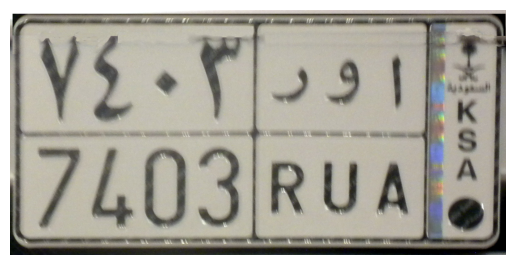

In [ ]:
image1 = cv2.imread("/content/Saudi_Arabia_license_plate_2014_North_American_size.jpeg")

image_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb1)
plt.axis('off')
plt.show()

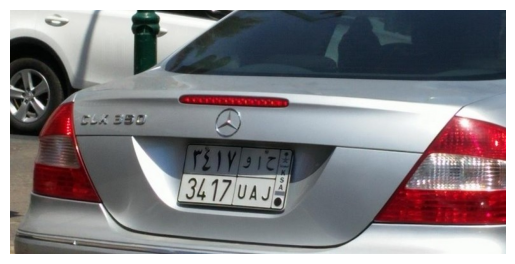

In [ ]:
image2 = cv2.imread("/content/Saudi-e1437914788448.jpg")

image_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb2)
plt.axis('off')
plt.show()

In [ ]:
n , m = lpd.forward(image_rgb1)


0: 96x192 2 0s, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 2.9ms postprocess per image at shape (1, 3, 96, 192)
19


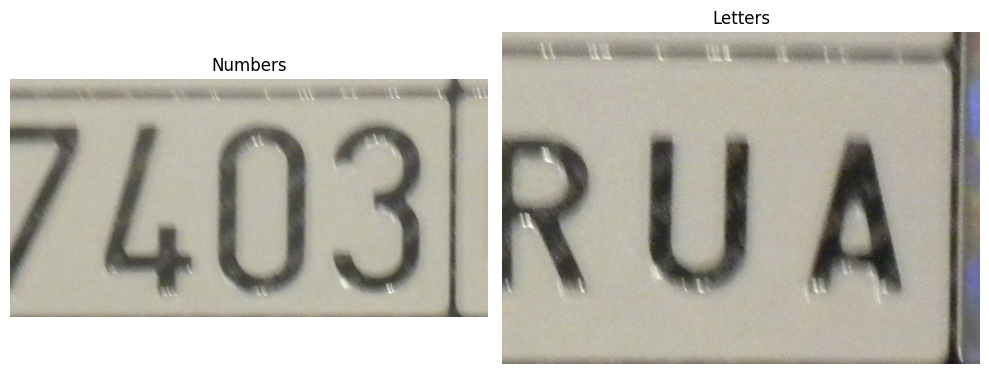

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(n, cmap='gray')
plt.title('Numbers')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(m, cmap='gray')
plt.title('Letters')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
v , c = lpd.forward(image_rgb2)


0: 96x192 1 0, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 192)


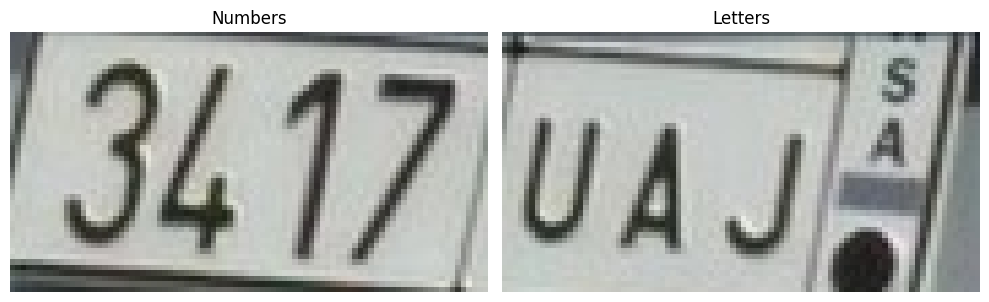

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(v, cmap='gray')
plt.title('Numbers')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(c, cmap='gray')
plt.title('Letters')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
lpr.forward(n,m)

tesxt 7403 conf :  0.9153323345943215
tesxt RUA conf :  0.9877702736460751
post_processed:  7403
post_processed:  RUA


'7403RUA'

In [ ]:
lpr.forward(v,c)

tesxt 3L17 conf :  0.7345526218414307
tesxt UAJE conf :  0.6626306772232056
post_processed:  3417
post_processed:  UAJ


'3417UAJ'